 - Inputs:
 
     . preprocessed BOLD in MNI152Lin2009cAsym space (from previous step) as input BOLD scan
     
     . confounds file generated by fmriprep
     
     . MNI T1 + ROIs in "src/corr_data"

In [1]:
import os
import glob
import sys
import pandas as pd

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
import SimpleITK as sitk
import nipype
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe
#from fsl.wrappers.melodic import fsl_regfilt # fsl_regfilt directly from fsl and not from nipype wrapper
import nipype.interfaces.fsl as fsl # numpy fsl
import nipype.interfaces.ants as ants
import nipype.interfaces.afni as afni
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface

In [2]:
# inBOLD='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/analysis/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_space-MNI152NLin2009cAsym_desc-smoothAROMAnonaggr_bold.nii.gz'
# inConf='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/analysis/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_desc-confounds_regressors.tsv'
# mniLabels='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/src/corr_data/dmn_thr3_4clustered_seedbased_correlation_2mm.nii.gz'
# mniBrainMask='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/src/corr_data/MNI152_T1_2mm_brain_mask.nii'
# trimNum=10

In [3]:
# inBOLD='/Users/aghayoor/Desktop/rsfmriExt_validation/data/fmriprep/sub-02008/ses-01/func/sub-02008_ses-01_task-rest_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'
# inConf='/Users/aghayoor/Desktop/rsfmriExt_validation/data/fmriprep/sub-02008/ses-01/func/sub-02008_ses-01_task-rest_desc-confounds_timeseries.tsv'
# mniLabels='/Users/aghayoor/Desktop/rsfmriExt_validation/src/corr_data/dmn_thr3_4clustered_seedbased_correlation_2mm.nii.gz'
# mniBrainMask='/Users/aghayoor/Desktop/rsfmriExt_validation/src/corr_data/MNI152_T1_2mm_brain_mask.nii'
# trimNum=10

In [4]:
inBOLD='/Users/aghayoor/Desktop/rsfmriExt_validation/data/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_space-MNI152NLin2009cAsym_desc-smoothAROMAnonaggr_bold.nii.gz'
inConf='/Users/aghayoor/Desktop/rsfmriExt_validation/data/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_desc-confounds_regressors.tsv'
mniLabels='/Users/aghayoor/Desktop/rsfmriExt_validation/src/corr_data/dmn_thr3_4clustered_seedbased_correlation_2mm.nii.gz'
mniBrainMask='/Users/aghayoor/Desktop/rsfmriExt_validation/src/corr_data/MNI152_T1_2mm_brain_mask.nii'
trimNum=10

In [5]:
BASE_DIR='/Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp'
WFname = 'rsfmriExt'

In [6]:
####### Workflow ################################
workflow = pe.Workflow(name=WFname, 
                       base_dir=BASE_DIR)

# Setup any package specific configuration. The output file format for FSL routines is being set to compressed NIFTI.
fsl.FSLCommand.set_default_output_type('NIFTI')

# define input and output
inputsSpec = pe.Node(interface=IdentityInterface(fields=['inputBOLD', 
                                                        'inputConfoundsFile',
                                                        'inputMNILables',
                                                        'inputMNIBrainMask',
                                                        'trimNumber']), 
                     name='inputsSpec')

inputsSpec.inputs.inputBOLD = inBOLD
inputsSpec.inputs.inputConfoundsFile = inConf
inputsSpec.inputs.inputMNILables = mniLabels
inputsSpec.inputs.inputMNIBrainMask = mniBrainMask
inputsSpec.inputs.trimNumber = trimNum

outputsSpec = pe.Node(interface=IdentityInterface(fields=['out_file_bp',
                                                          'out_file_bp_mean',
                                                          'correlation_stats']),
                      name='outputsSpec')

### step 1: trim the input

# def get_t_size(in_file, trimNum):
#     from ants import image_header_info
#     h = image_header_info(in_file)
#     length = h['dimensions'][3]
#     tsize = length - trimNum
#     return int(tsize)

def get_t_size(in_file, trimNum):
    import nibabel as nb
    img = nb.load(in_file)
    header = img.header
    length = header.get_data_shape()[3]
    tsize = length - trimNum
    return int(tsize)

getTsize = pe.Node(interface=Function(function = get_t_size, 
                                       input_names=['in_file', 'trimNum'],
                                       output_names=['tsize']), 
                    name="get_t_size")
workflow.connect(inputsSpec, 'inputBOLD', getTsize, 'in_file')
workflow.connect(inputsSpec, 'trimNumber', getTsize, 'trimNum')

trim = pe.Node(interface=fsl.ExtractROI(), name='trim_bold')

trim.inputs.roi_file = 'bold_trimmed.nii'
workflow.connect(inputsSpec, 'inputBOLD', trim, 'in_file')
workflow.connect(inputsSpec, 'trimNumber', trim, 't_min')
workflow.connect(getTsize, 'tsize', trim, 't_size')

### step 2: run regression by fsl_regfilt

# def trim_matrix(in_confound_file, trimNum):
#     import os
#     out_confound_file = os.path.realpath('trimmed_confound_matrix.tsv')
#     with open(in_confound_file, 'r') as fin:
#         data = fin.read().splitlines(True)
#     with open(out_confound_file, 'w') as fout:
#         fout.writelines(data[trimNum+1:])
#     return out_confound_file

def trim_matrix(in_confound_file, trimNum):
    import os
    import pandas as pd
    out_confound_file = os.path.realpath('trimmed_confound_matrix.tsv')
    df = pd.read_csv(in_confound_file,sep='\t')
    #
#     #
#     # keep the columns used to run the regression
#     headers_to_keep = ['csf','white_matter','framewise_displacement']
#     out_df = df[headers_to_keep]
#     # trim the rows
#     out_df = out_df.truncate(before=trimNum)
#     out_df.to_csv(out_confound_file,na_rep='nan',index=False,header=False,sep='\t')
#     return out_confound_file
#     #
    #
    # select the columns indices for the regressors we use
    regressors = ['csf','white_matter','framewise_displacement']
    regressors_indices = [df.columns.get_loc(c)+1 for c in regressors if c in df]
    # trim the rows
    df = df.truncate(before=trimNum)
    df.to_csv(out_confound_file,na_rep='nan',index=False,header=False,sep='\t')
    return [out_confound_file, regressors_indices]

trimMatrix = pe.Node(interface=Function(function = trim_matrix, 
                                       input_names=['in_confound_file','trimNum'],
                                       output_names=['out_confound_file','regressors_indices']), 
                    name="trim_confound_matrix")

workflow.connect(inputsSpec, 'trimNumber', trimMatrix, 'trimNum')
workflow.connect(inputsSpec, 'inputConfoundsFile', trimMatrix, 'in_confound_file')

# wrapper for fsl_regfilt
regression = pe.Node(interface=fsl.FilterRegressor(), name='regression')

regression.inputs.out_file = 'bold_trimmed_wmcsfreg.nii'
workflow.connect(trim, 'roi_file', regression, 'in_file')
workflow.connect(trimMatrix, 'regressors_indices', regression, 'filter_columns')
workflow.connect(trimMatrix, 'out_confound_file', regression, 'design_file')
workflow.connect(inputsSpec, 'inputMNIBrainMask', regression, 'mask')

### step 3: band pass filtering

def calculate_sigmas(in_file):
#     def get_tr(in_file):
#         from ants import image_header_info
#         h = image_header_info(in_file)
#         tr = h['spacing'][3]
#         return tr
    def get_tr(in_file):
        import nibabel as nb
        img = nb.load(in_file)
        header = img.header
        tr = header.get_zooms()[3]
        return tr

    tr = get_tr(in_file)
    f_hi = 0.01
    hp_sigma = 1/(2.0*f_hi*tr)
    f_lo = 0.1
    lp_sigma = 1/(4.0*f_lo*tr)
    #out = str(hp_sigma) + ' ' + str(lp_sigma)
    #return out
    return [lp_sigma, hp_sigma]

calcSigmas = pe.Node(interface=Function(function = calculate_sigmas, 
                                    input_names=['in_file'],
                                    output_names=['lp_sigma', 'hp_sigma']), 
                    name="calculate_hplp")

workflow.connect(inputsSpec, 'inputBOLD', calcSigmas, 'in_file')

## NOTE: As an alternative, you could also use "TemporalFilter" from fsl for bandpass filtering
# bandpass = pe.Node(interface=fsl.ImageMaths(op_string='-bptf', suffix='_bptf'),
#                 name='bandpass')

# bandpass.inputs.out_file = 'bold_trimmed_wmcsfreg_bp.nii'
# workflow.connect(calcSigmas, 'out', bandpass, 'args')
# workflow.connect(regression, 'out_file', bandpass, 'in_file')
# workflow.connect(bandpass, 'out_file', outputsSpec, 'out_file_bp')

bandpass = pe.Node(interface=fsl.TemporalFilter(), name='bandpass')

bandpass.inputs.out_file = 'bold_trimmed_wmcsfreg_bp.nii'
workflow.connect(regression, 'out_file', bandpass, 'in_file')
workflow.connect(calcSigmas, 'lp_sigma', bandpass, 'lowpass_sigma')
workflow.connect(calcSigmas, 'hp_sigma', bandpass, 'highpass_sigma')
workflow.connect(bandpass, 'out_file', outputsSpec, 'out_file_bp')

## Now take the mean for reference
mean = pe.Node(interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
                name='mean')

mean.inputs.out_file = 'bold_trimmed_wmcsfreg_bp_mean.nii'
workflow.connect(bandpass, 'out_file', mean, 'in_file')
workflow.connect(mean, 'out_file', outputsSpec, 'out_file_bp_mean')

### step 4: correlation maps using afni
ncorr = pe.Node(interface=afni.NetCorr(), name='correlation')

ncorr.inputs.ts_out = True
ncorr.inputs.ts_label = True
ncorr.inputs.ts_wb_strlabel = True
ncorr.inputs.nifti = True
ncorr.inputs.ts_wb_corr = True
ncorr.inputs.ts_wb_Z = True
ncorr.inputs.fish_z = True
ncorr.inputs.out_file = 'sub0.tp1.ncorr'
#ncorr.inputs.out_file = os.path.realpath('sub.t.ncorr')
workflow.connect(bandpass, 'out_file', ncorr, 'in_file')
workflow.connect(inputsSpec, 'inputMNILables', ncorr, 'in_rois')
workflow.connect(inputsSpec, 'inputMNIBrainMask', ncorr, 'mask')
workflow.connect(ncorr, 'out_matrix', outputsSpec, 'correlation_stats')

workflow.write_graph("workflow_graph.dot")

210113-10:09:14,546 nipype.workflow INFO:
	 Generated workflow graph: /Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'/Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/workflow_graph.png'

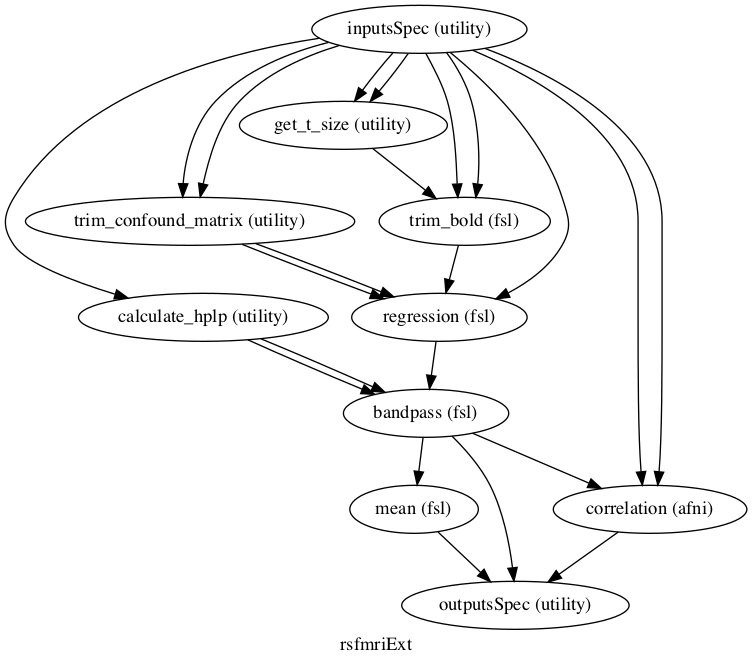

In [7]:
from IPython.display import Image
fn = BASE_DIR + '/' + WFname + '/' + 'workflow_graph.png'
Image(filename=fn)

In [8]:
workflow.config['execution'] = {'remove_unnecessary_outputs': 'False'}
workflow.run()

210113-10:09:14,654 nipype.workflow INFO:
	 Workflow rsfmriExt settings: ['check', 'execution', 'logging', 'monitoring']
210113-10:09:14,682 nipype.workflow INFO:
	 Running serially.
210113-10:09:14,683 nipype.workflow INFO:
	 [Node] Setting-up "rsfmriExt.calculate_hplp" in "/Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/calculate_hplp".
210113-10:09:14,689 nipype.workflow INFO:
	 [Node] Running "calculate_hplp" ("nipype.interfaces.utility.wrappers.Function")
210113-10:09:14,698 nipype.workflow INFO:
	 [Node] Finished "rsfmriExt.calculate_hplp".
210113-10:09:14,699 nipype.workflow INFO:
	 [Node] Setting-up "rsfmriExt.trim_confound_matrix" in "/Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/trim_confound_matrix".
210113-10:09:14,703 nipype.workflow INFO:
	 [Node] Running "trim_confound_matrix" ("nipype.interfaces.utility.wrappers.Function")
210113-10:09:14,746 nipype.workflow INFO:
	 [Node] Finished "rsfmriExt.trim_confound_matrix".
210113-10:09:14,747 nip

210113-10:10:37,113 nipype.workflow INFO:
	 [Node] Finished "rsfmriExt.correlation".
210113-10:10:37,114 nipype.workflow INFO:
	 [Node] Setting-up "rsfmriExt.mean" in "/Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/mean".
210113-10:10:37,120 nipype.workflow INFO:
	 [Node] Running "mean" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /Users/aghayoor/Desktop/rsfmriExt_validation/out_tmp/rsfmriExt/bandpass/bold_trimmed_wmcsfreg_bp.nii -Tmean bold_trimmed_wmcsfreg_bp_mean.nii
210113-10:10:41,295 nipype.workflow INFO:
	 [Node] Finished "rsfmriExt.mean".


In [12]:
# def get_t_size(in_file, trimNum):
#     from ants import image_header_info
#     h = image_header_info(in_file)
#     length = h['dimensions'][3]
#     tsize = length - trimNum
#     return int(tsize)

# print(get_t_size(inBOLD,10))

# def get_t_size_new(in_file, trimNum):
#     import nibabel as nb
#     img = nb.load(in_file)
#     header = img.header
#     length = header.get_data_shape()[3]
#     tsize = length - trimNum
#     return int(tsize)

# print(get_t_size_new(inBOLD,10))

In [13]:
# def get_tr(in_file):
#     from ants import image_header_info
#     h = image_header_info(in_file)
#     tr = h['spacing'][3]
#     return tr

# print(get_tr(inBOLD))

# def get_tr_new(in_file):
#     import nibabel as nb
#     img = nb.load(in_file)
#     header = img.header
#     tr = header.get_zooms()[3]
#     return tr

# print(get_tr_new(inBOLD))

In [14]:
# ncorr = afni.NetCorr()
# ncorr.inputs.in_file = '/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/bandpass/bold_trimmed_wmcsfreg_bp.nii'
# ncorr.inputs.mask = mniBrainMask
# ncorr.inputs.in_rois = mniLabels
# ncorr.inputs.ts_wb_corr = True
# ncorr.inputs.ts_wb_Z = True
# ncorr.inputs.fish_z = True
# ncorr.inputs.nifti = True
# ncorr.inputs.out_file = '/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/correlation/sub0.tp1.ncorr'
# ncorr.cmdline # doctest: +SKIP

In [15]:
# res = ncorr.run()

In [16]:
# res.outputs